# FRED Economic Dashboard with OpenAI Real‑Time Analysis

This notebook fetches key U.S. economic indicators from the **St. Louis Fed FRED** database and asks **OpenAI GPT‑4o** to generate concise, real‑time commentary for each chart.

## 1  Installation
Run this once in a terminal (not in the notebook) if the libraries are missing:
```bash
pip install fredapi pandas matplotlib openai python-dotenv
```

## 2  Obtain API Keys
### 2.1  FRED API Key
1. Create or sign in to your account at <https://fred.stlouisfed.org>.
2. Go to **My Account → API Keys**.
3. Click **Generate** (or copy your existing key).

### 2.2  OpenAI API Key
1. Sign in to your OpenAI account and open <https://platform.openai.com/account/api-keys>.
2. Click **Create new secret key** and copy it immediately — you won't see it again.

## 3  Set Environment Variables
### 3.1  Temporary (per terminal session)
**Command Prompt**
```cmd
set FRED_API_KEY=your-fred-key
set OPENAI_API_KEY=your-openai-key
```
**PowerShell**
```powershell
$env:FRED_API_KEY="your-fred-key"
$env:OPENAI_API_KEY="your-openai-key"
```

### 3.2  Permanent (System Settings)
1. Search *Environment Variables* → **Edit the system environment variables**.
2. Click **Environment Variables…** → under *User variables* click **New…** and add
   `FRED_API_KEY` and `OPENAI_API_KEY`.

### 3.3  Project‑Local `.env` File *(recommended for notebooks)*
Create a file named `.env` in the same folder as this notebook:
```text
FRED_API_KEY=your-fred-key
OPENAI_API_KEY=your-openai-key
```
The next cell loads these automatically via **python‑dotenv**.

In [1]:
import os
from dotenv import load_dotenv

# Load .env file if present
load_dotenv()

# Grab keys from environment
FRED_API_KEY = os.getenv('FRED_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

assert FRED_API_KEY, 'FRED_API_KEY not found. Set it via env vars or a .env file.'
assert OPENAI_API_KEY, 'OPENAI_API_KEY not found. Set it via env vars or a .env file.'

print('✅ Keys loaded successfully')

✅ Keys loaded successfully


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from fredapi import Fred
from openai import OpenAI
from IPython.display import display, HTML

# openai.api_key = OPENAI_API_KEY

# Configure list of FRED series (code: label)
fred_series = {
    'T10Y2Y': '10Y‑2Y Yield Spread',
    'ICSA': 'Initial Jobless Claims',
    'UMCSENT': 'Consumer Sentiment Index',
    'USSLIND': 'Leading Economic Index',
    'DRCLACBS': 'Consumer Loan Delinquencies',
    'DRCCLACBS': 'Credit Card Delinquencies',
    'UNRATE': 'Unemployment Rate',
    'CORBLACBS': 'Bank Charge‑Off Rate',
    'DRBLACBS': 'Business Loan Delinquencies',
    'INDPRO': 'Industrial Production',
    'DGORDER': 'Durable Goods Orders',
    'PSAVERT': 'Personal Savings Rate',
    'CIVPART': 'Labor Force Participation',
    'CUSR0000SEHA': 'CPI Rent Equivalent',
    'PAYEMS': 'Nonfarm Payrolls',
}

fred = Fred(api_key=FRED_API_KEY)
client = OpenAI()

In [4]:
def fetch_fred_data(series_dict, years=5):
    """Return a DataFrame with Date + one column per indicator."""
    start_date = datetime.now().replace(year=datetime.now().year - years)
    df_master = pd.DataFrame()
    for code, label in series_dict.items():
        data = fred.get_series(code, start_date=start_date)
        df = pd.DataFrame(data).reset_index()
        df.columns = ['Date', label]
        df_master = df if df_master.empty else df_master.merge(df, on='Date', how='outer')
    return df_master.sort_values('Date').ffill()

In [5]:
def ai_analyze_series(label: str, series: pd.Series) -> str | None:
    current_val = series.dropna().iloc[-1]
    one_year_ago = series.dropna().iloc[-253] if len(series) > 253 else None
    trend = (
        "increasing" if one_year_ago is not None and current_val > one_year_ago
        else "decreasing" if one_year_ago is not None
        else "—"
    )
    one_year_txt = f"{one_year_ago:.2f}" if one_year_ago is not None else "N/A"

    prompt = (
        f"You are a macro-economic analyst.\n"
        f"Indicator: **{label}**\n"
        f"Current value: {current_val:.2f}\n"
        f"Value one year ago: {one_year_txt}\n"
        f"Trend: {trend}.\n\n"
        f"In 2-3 bullet points, interpret what this implies for the U.S. economy."
    )

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.3,
            max_tokens=150,
        )
        return response.choices[0].message.content.strip()
    except Exception as exc:
        return f"(AI summary failed: {exc})"

In [ ]:
# def ai_analyze_series(label, series):
#     """Return a short GPT summary of the latest trend."""
#     current_val = series.dropna().iloc[-1]
#     one_year_ago = series.dropna().iloc[-253] if len(series) > 253 else None
#     trend = (
#         'increasing' if one_year_ago is not None and current_val > one_year_ago else
#         'decreasing' if one_year_ago is not None else '—'
#     )
#     one_year_text = f'{one_year_ago:.2f}' if one_year_ago is not None else 'N/A'

#     prompt = (
#         f'You are a macro‑economic analyst. The user provides a 5‑year time series for **{label}**.'
#         f'\nCurrent value: {current_val:.2f}\nValue one year ago: {one_year_text}\nTrend: {trend}.'
#         f'\n\nIn 2‑3 bullet points, interpret what this indicator implies for the U.S. economy right now.'
#     )

#     response = openai.ChatCompletion.create(
#         model='gpt-4o-preview',
#         messages=[{'role': 'user', 'content': prompt}],
#         temperature=0.3,
#         max_tokens=150,
#     )
#     return response.choices[0].message.content.strip()

In [6]:
def render_chart(df, col):
    plt.figure(figsize=(10, 4))
    plt.plot(df['Date'], df[col])
    plt.title(col)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    summary = ai_analyze_series(col, df[col])
    if summary:
        print("\n**AI Summary:**")
        display(HTML(f'''
        <div style="white-space: pre-wrap; max-width: 100ch; font-family: monospace; padding: 0.5em; border-left: 3px solid #ccc;">
            {summary}
        </div>
        '''))
    else:
        print("\n(No AI summary available.)")
    # print('\n**AI Summary:**')
    # print(ai_analyze_series(col, df[col]))

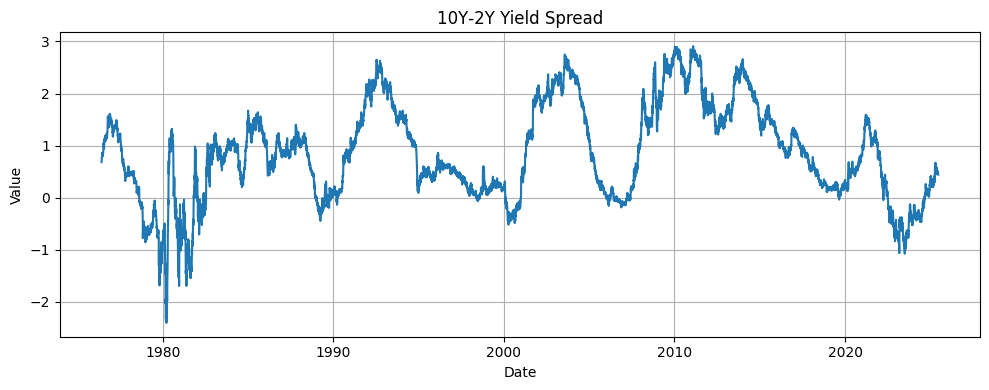


**AI Summary:**


------------------------------------------------------------


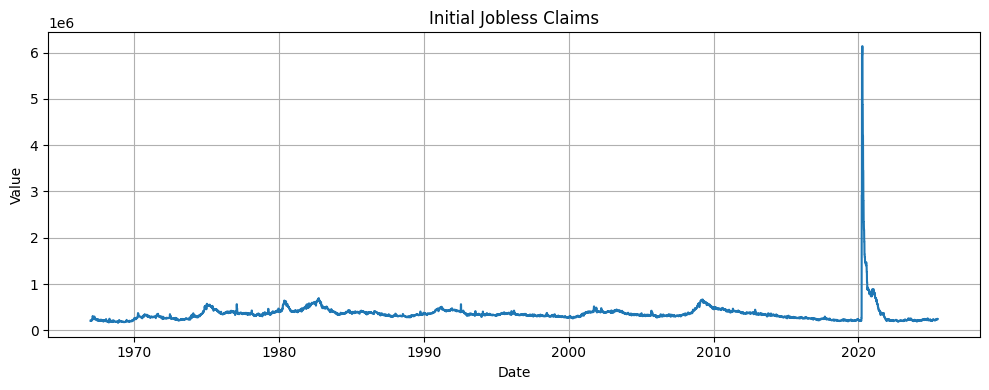


**AI Summary:**


------------------------------------------------------------


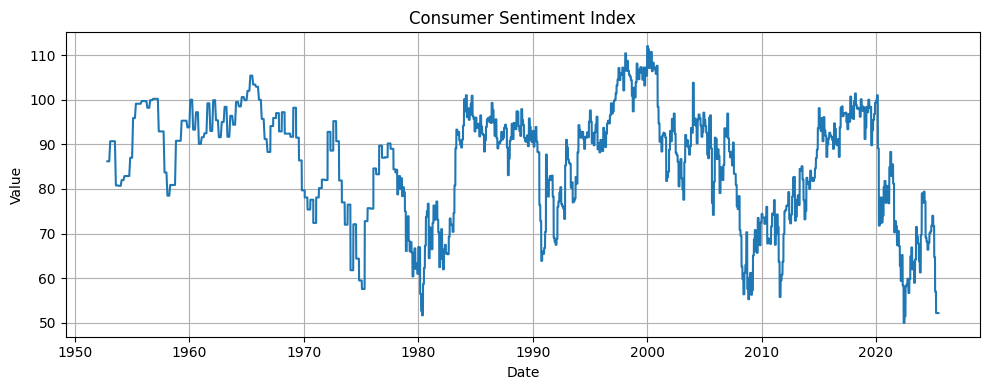


**AI Summary:**


------------------------------------------------------------


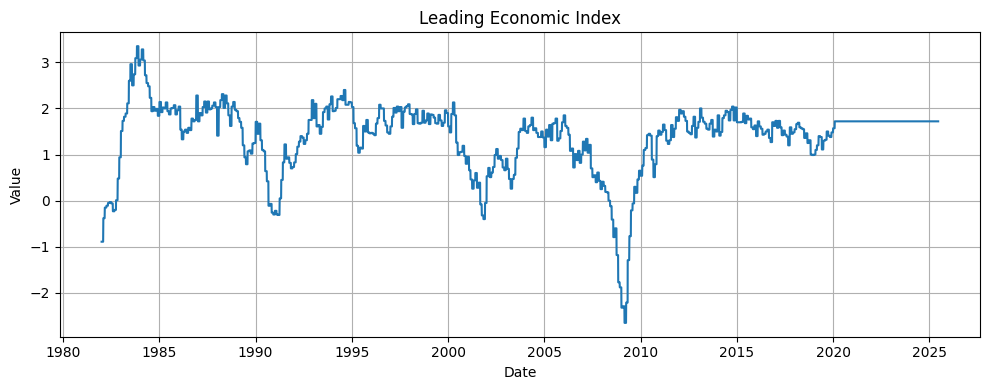


**AI Summary:**


------------------------------------------------------------


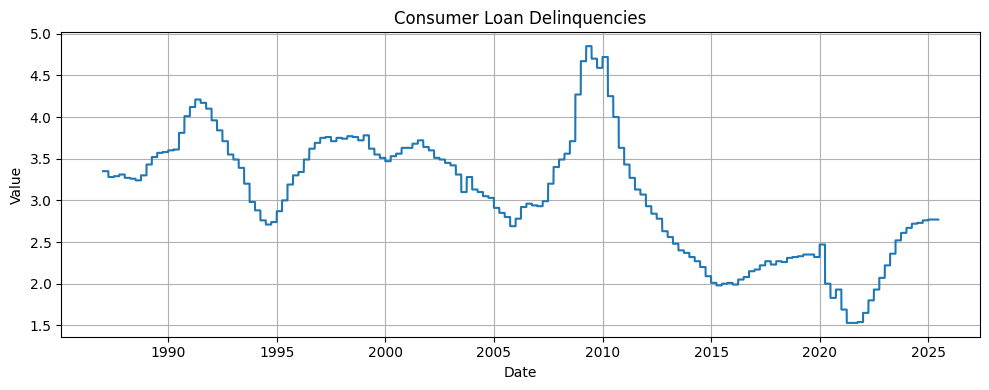


**AI Summary:**


------------------------------------------------------------


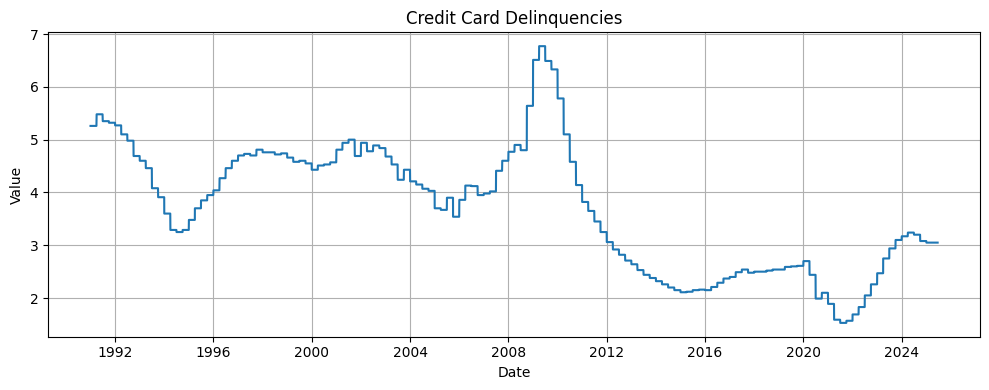


**AI Summary:**


------------------------------------------------------------


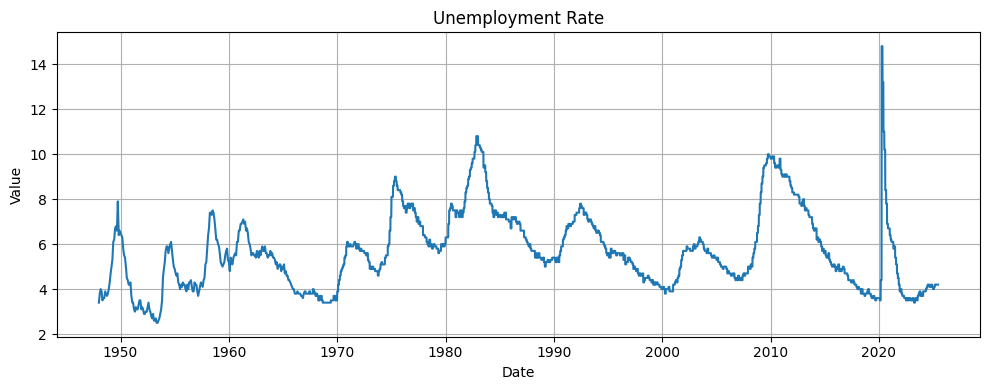


**AI Summary:**


------------------------------------------------------------


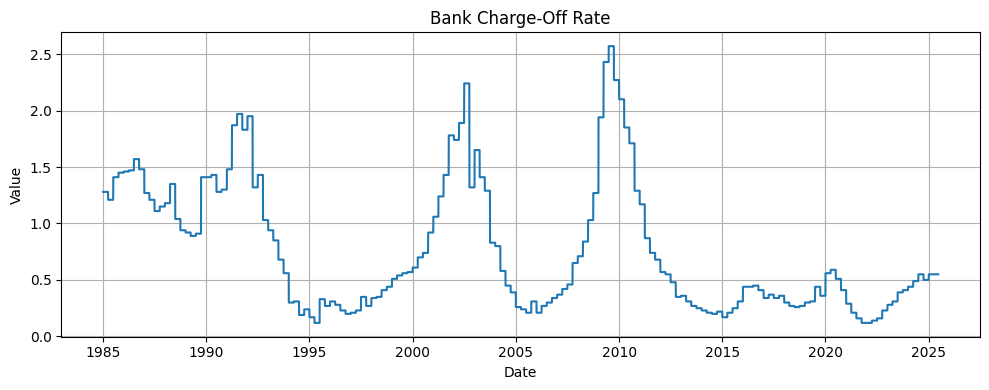


**AI Summary:**


------------------------------------------------------------


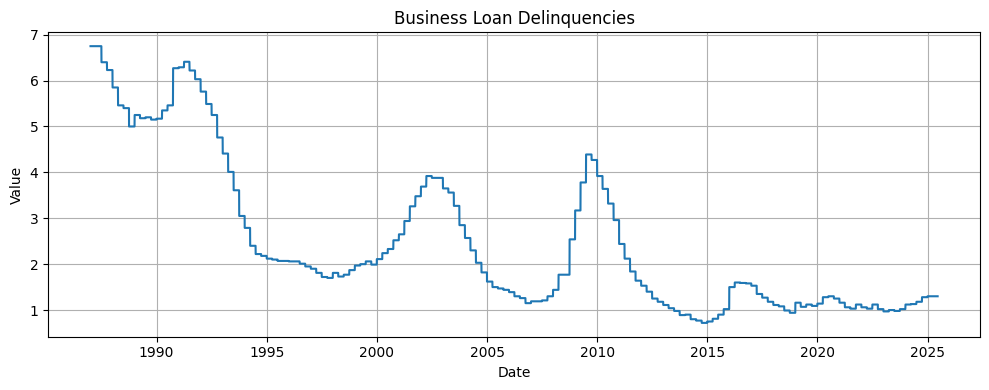


**AI Summary:**


------------------------------------------------------------


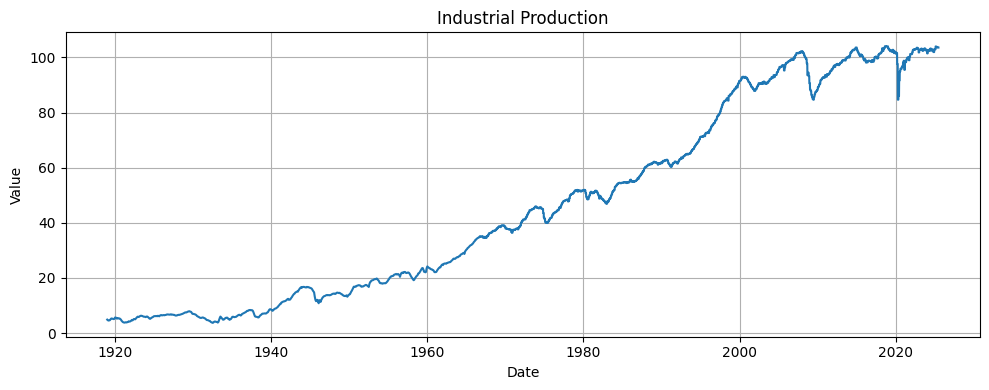


**AI Summary:**


------------------------------------------------------------


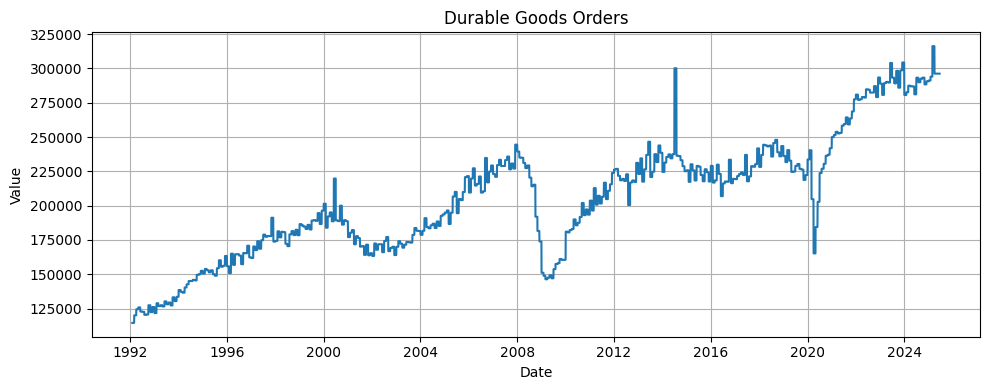


**AI Summary:**


------------------------------------------------------------


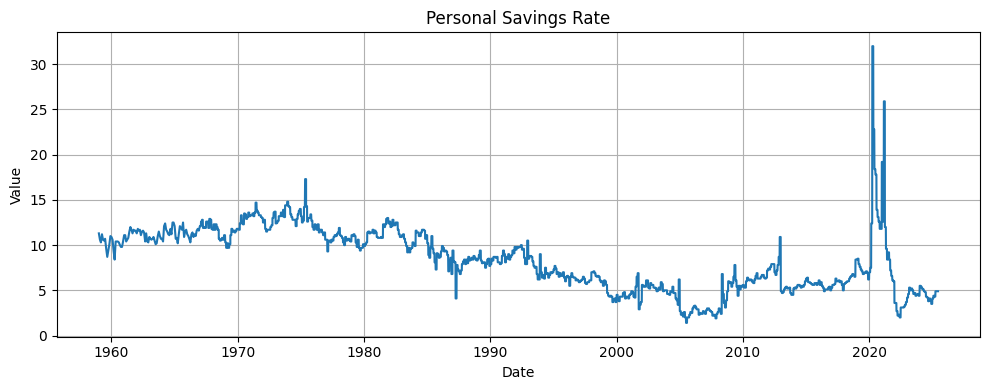


**AI Summary:**


------------------------------------------------------------


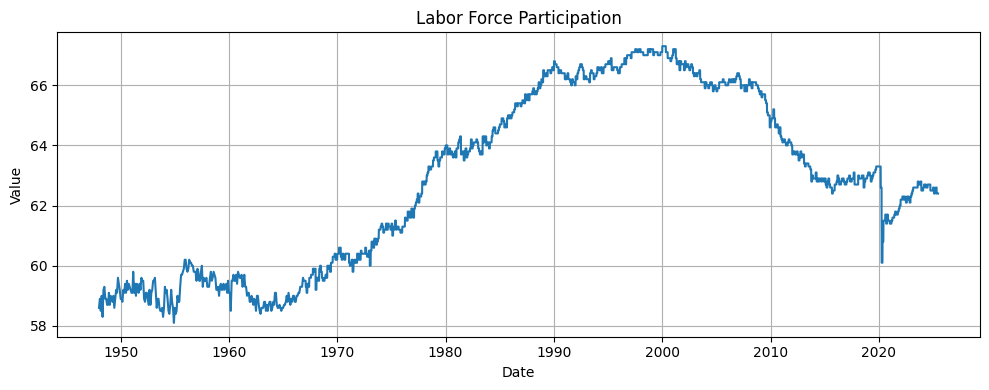


**AI Summary:**


------------------------------------------------------------


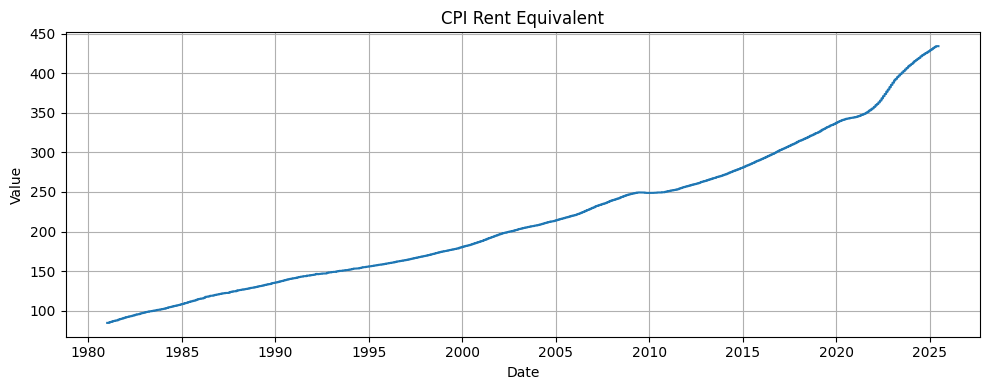


**AI Summary:**


------------------------------------------------------------


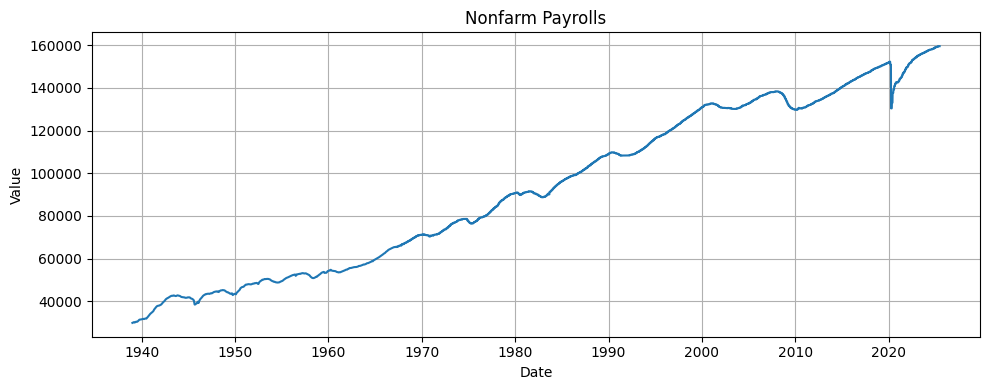


**AI Summary:**


------------------------------------------------------------


In [7]:
# 🔄 Fetch data & render charts
data = fetch_fred_data(fred_series, years=5)

for column in data.columns[1:]:  # skip 'Date'
    render_chart(data, column)
    print('-' * 60)